# 2 beam configuration study

- [Introduction](#Introduction)
    - [Structure](#Structure)
    - [Setup](#Setup)
    - [Ewald circle](#Ewald-circle) 
    - [Potential](#Potential)
- [Simulation with multi2D](#Simulation-with-multi2D)
    - [Potential sampling](#potential-sampling)
- [Simulation with bloch2D](#Simulation-with-blochwave)

A comparison between multislice and blochwave of a 2-beam configuration electron diffraction setup.

In [4]:
from utils import*
import importlib as imp
import os
import wallpp.lattice as lat        ;imp.reload(lat)
import wallpp.plane_group as pg     ;imp.reload(pg)
import multislice.multi_2D as ms    ;imp.reload(ms)
import multislice.pymultislice as pyms;imp.reload(pyms)
#plt.close('all')
path='figures/2_beam_'
opts='TMv'#MK'
opt = 'p'

## Introduction
### Structure
The structure is a simple primitive square lattice with unique atom. 

/home/tarik/Documents/git/mygit/utilities/utils/displayStandards.py:749: UserWarning: Matplotlib is currently using GTK3Agg, which is a non-GUI backend, so cannot show the figure.
  if 'p' in opt : ax.figure.show()


(<Figure size 480x480 with 1 Axes>,
 <AxesSubplot:xlabel='$k_x(\\AA)$', ylabel='$k_z(\\AA})$'>)

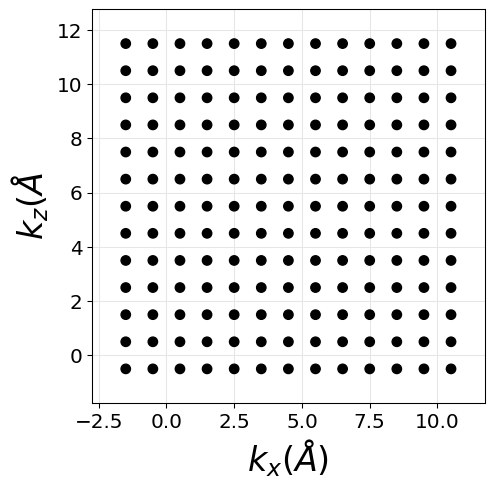

In [5]:
## lattice structure 
pptype,ax,bz,angle = 'p1',1,1,90
Za = 2                 #atom type
n  = 10                #number of unit cells
pattern = np.array([[0.5,0.5,Za]])
a1,a2 = lat.set_lattice_vec(lat_type='rect',a=ax,b=bz)
b1,b2 = lat.reciprocal_lattice_2D(a1,a2)

### real lattice
x0,z0 = np.meshgrid(np.arange(-2,n+1),np.arange(-1,n+2))
x0,z0 = np.stack([x0*ax+pattern[0][0],z0*bz+pattern[0][1]])

plts=[]
scat  = [x0,z0,50,'k']
dsp.stddisp(plts,scat=scat,figsize=(5,)*2,labs=[r'$k_x(\AA)$',r'$k_z(\AA})$'])

### Setup
The incident beam energy and crystal orientation are chosen so that the setup is exactly in a 2 beam configuration.

In [6]:
## incident beam
K   = 5.024937810560445     # wave vector
keV = cst.lam2keV(1/K)#200  # energy 
lam = 1/K                   # wavelength
sig = cst.keV2sigma(keV)    # interaction parameter


## orientation 
theta = np.arctan(1/n)  #orientation of the 2D crystal
rot   = lambda t:np.array([[np.cos(t),np.sin(t)],[-np.sin(t),np.cos(t)]])
### rotated lattice
Xa    = rot(theta).dot(np.stack([x0.flatten(),z0.flatten()]))


### Ewald circle
The Ewald sphere configuration for the setup is obtained as : 

/home/tarik/Documents/git/mygit/utilities/utils/displayStandards.py:749: UserWarning: Matplotlib is currently using GTK3Agg, which is a non-GUI backend, so cannot show the figure.
  if 'p' in opt : ax.figure.show()


(<Figure size 480x480 with 1 Axes>,
 <AxesSubplot:xlabel='$k_x(\\AA^{-1})$', ylabel='$k_z(\\AA^{-1})$'>)

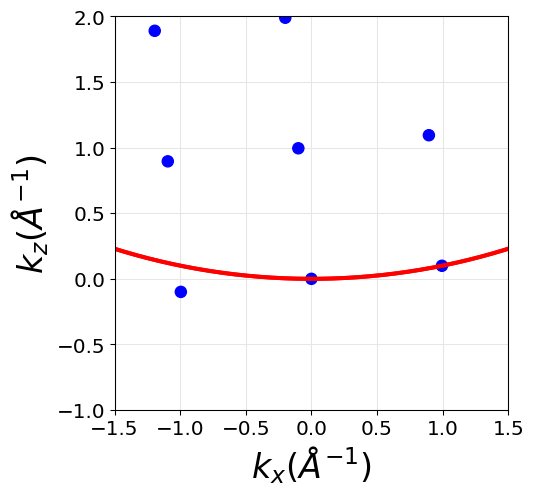

In [8]:
### plts = []
###ewald circle
t  = -np.pi/2 + np.pi/4*np.linspace(-1,1,1000)
plts += [[K*np.cos(t),K*(1+np.sin(t)),'r','']]

# reciprocal lattice
nh,nk = n,n
b1,b2 = lat.reciprocal_lattice_2D(a1,a2)
h,k = np.meshgrid(np.arange(-nh,nh+1),np.arange(nk))
X = h*b1[0]+k*b2[0]
Z = h*b1[1]+k*b2[1]
## rotate the reciprocal lattice
X,Z  = rot(-theta).dot(np.stack([X.flatten(),Z.flatten()]))

q=np.linalg.norm(np.array([X.flatten(),Z.flatten()]),axis=0)
df_G=pd.DataFrame(np.array([h.flatten(),k.flatten(),X.flatten(),Z.flatten(),q]).T,
                columns=['h','k','X','Z','q'])
df_G.index=[(str((h,k))) for h,k in df_G[['h','k']].values.astype(int)]
# print(df.loc[str((1,0)),['X','Z','q']])

if False:
    H    = Nz*bz
    zeta = np.linspace(0,0.25/bz,100)
    Fz   = lambda i : 1/(1.1*self.ax)*np.sinc(zeta*H)**2+i/self.ax
    plts +=[[Fz(i),zeta,'b--',''] for i in range(nh)]

scat  = [X,Z,70,'b']
dsp.stddisp(plts,scat=scat,labs=[r'$k_x(\AA^{-1})$',r'$k_z(\AA^{-1})$'],lw=3,
            figsize=(5,)*2,xylims=[-1.5,1.5,-1,2])

### Potential 
The potential is a simple isotropic Gaussian type potential :

\begin{equation}
    V(r)=exp^{-\left(\frac{r}{A_Z}\right)^2}
\end{equation}

where $A_Z$ depends on the atom type.

/home/tarik/Documents/git/mygit/utilities/utils/displayStandards.py:749: UserWarning: Matplotlib is currently using GTK3Agg, which is a non-GUI backend, so cannot show the figure.
  if 'p' in opt : ax.figure.show()


(None, <AxesSubplot:xlabel='$x(\\AA)$', ylabel='$y(\\AA)$'>)

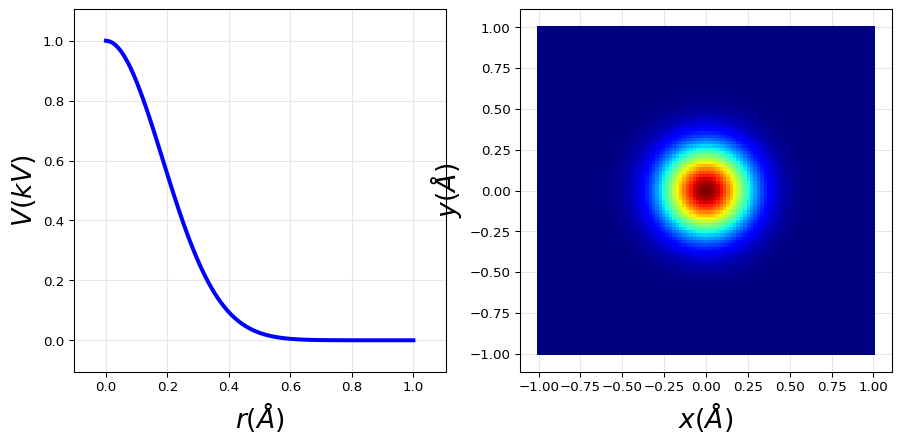

In [9]:
## parameters
eps=0.01 #potential strenght scaling factor


npts=100
r=np.linspace(0,1,npts)
f_V=pg.f_V(r,Za)

fig,(ax1,ax2)=dsp.create_fig(rc=(1,2),figsize=(11,5))
args=dict(setPos=False,fonts={'lab':20,'tick':10})
dsp.stddisp([r,f_V,'b-'],ax=ax1,labs=[r'$r(\AA)$',r'$V(kV)$'],lw=3,**args)

xv,zv = np.meshgrid(*[np.linspace(-1,1,npts)]*2)
fv=np.reshape(pg.fv(np.stack([xv.flatten(),zv.flatten()]).T,0,Za),(npts,)*2)
dsp.stddisp(im=[xv,zv,fv],ax=ax2,labs=[r'$x(\AA)$',r'$y(\AA)$'],lw=3,**args)


The corresponding form factor is obtained from its fourier transform :

\begin{eqnarray}
    f(q)
        &=& \frac{2\pi me}{h^2}\int V(r)e^{2j\pi qr}dr^3\\
        &=& \frac{\sigma}{\lambda}\mathcal V\\
        &=& \frac{\sigma}{\lambda}\sqrt{\pi}A_Z e^{-\pi A_Z^2q^2}
\end{eqnarray}

where $q=\sin(\theta)/\lambda$.



/home/tarik/Documents/git/mygit/utilities/utils/displayStandards.py:749: UserWarning: Matplotlib is currently using GTK3Agg, which is a non-GUI backend, so cannot show the figure.
  if 'p' in opt : ax.figure.show()
/home/tarik/Documents/git/mygit/utilities/utils/displayStandards.py:749: UserWarning: Matplotlib is currently using GTK3Agg, which is a non-GUI backend, so cannot show the figure.
  if 'p' in opt : ax.figure.show()


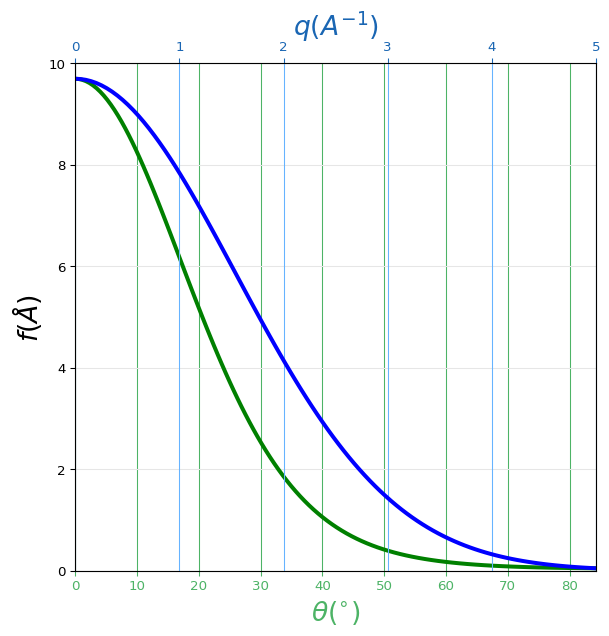

In [10]:
Az=pg.Ai[Za]
q=np.linspace(0,5,npts)

thetas=np.rad2deg(np.arcsin(q*lam))
F_V=sig/lam*np.sqrt(np.pi)*Az*np.exp(-np.pi*(Az*q)**2)

c0=(0.3,0.7,0.4)
fig,axF=dsp.stddisp([thetas,F_V,'g'],labs=[r'$\theta(^{\circ})$',r'$f(\AA)$'],
                    xylims=[0,thetas.max(),0,10],figsize=(7,)*2,lw=3,c=[c0,'k'],**args)
axF.grid(color=c0,axis='x')

axF2 = axF.twiny()
c1=(0.1,0.4,0.7)
dsp.pltPlots(axF2,[q,F_V,'b',''],lw0=3)
dsp.standardDisplay(axF2,labs=['$q(A^{-1}$)',''],c=[c1,'k'],xylims=[0,q.max(),0,10],**args)
axF2.tick_params('x',color=c1)
axF2.grid(color=tuple(np.array(c1)+0.3))


Note that in Blochwave the structure being periodic, the Fourier components are calculated over the unit cell so that : 

\begin{eqnarray}
    U_g
        &=& \frac{2me}{h^2 V_{cell}}\int V(r)e^{2j\pi gr}dr^2\\
        &=& \frac{\sigma}{\pi\lambda V_{cell}}\mathcal V_g
\end{eqnarray}

and the pendullosung thickness : 

\begin{eqnarray}
    \zeta_g 
        &=& \frac{k_0}{U_g}\\
        &=& \frac{\pi V_{cell}}{\sigma \mathcal V_g}\\
\end{eqnarray}

In this 2 beam setup, the excited beam is (1,0) which has $q=1/a_x$.

In [11]:
q_g=1/ax
Vcell=ax*bz
Vg=2*np.pi*np.sqrt(np.pi)*Az*np.exp(-np.pi*(Az*q_g)**2)/Vcell
zeta=np.pi/(eps*sig*Vg)
print('sig=%.2f /kV/A, lam=%.2f A, sig/lam=%.2f /kV' %(sig,lam,sig/lam))
print('Vg=%.2f, zeta=%.2f A' %(Vg,zeta))

sig=4.19 /kV/A, lam=0.20 A, sig/lam=21.04 /kV
Vg=2.34, zeta=32.04 A


## Simulation with multi2D

### Potential sampling

In multislice we need to define the potential over a the simulation grid which needs to be sampled. 
The pattern is repeated in a super cell `ax1`,`bz1` and rotated by a small angle to setup a 2 beam configuration. The super cell is chosen to maintain periodic boundary condition.

In [13]:
new_pot=True
pot_file='dat/2_beam.npy'

## sampling 
Nx,Nz = 1,5000     # unit cells
ndeg  = 2**6       # number of pixels per unit cell
#np = Nx*ndeg# unsued
#Nh = 20

## super cell size
ax1 = np.sqrt(1**2+n**2)*ax
bz1 = ax1


if not os.path.exists(pot_file) or new_pot:
    # p1 = pg.Wallpaper(pptype,ax,bz,angle,pattern,ndeg=ndeg)
    # potential = p1.get_potential_grid()

    x,z = np.meshgrid(np.arange(n*ndeg)*ax1/(n*ndeg),np.arange(n*ndeg)*bz1/(n*ndeg))
    f = np.sum(np.array([pg.fv(np.stack([x.flatten(),z.flatten()]).T,X0,Za) for X0 in Xa.T]),axis=0)
    f = np.reshape(f,(n*ndeg,n*ndeg))
    np.save(pot_file,[x,z,f])

    scat=[Xa[0],Xa[1],15,'k']
else:
    scat=[]
    x,z,f = np.load('dat/2_beam.npy')
    print(colors.green+'potential loaded'+colors.black)

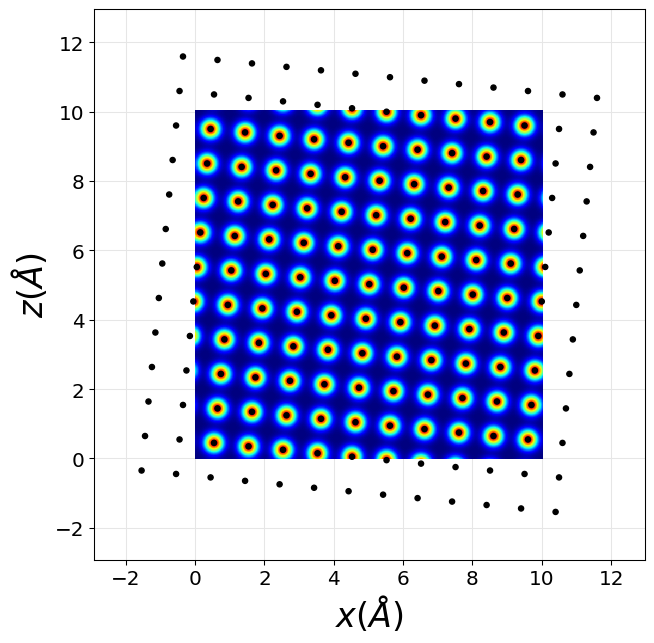

In [16]:
dsp.stddisp(im=[x,z,f],figsize=(7,)*2,scat=scat,labs=[r'$x(\AA)$',r'$z(\AA)$']
    ,name=path+'fv.png',opt=opt);

### simulation 
The simulation is launched specifying the potential grid. Unit cell constants, beam energy and super cell. A slight tilt angle is introduced to exactly be in the bragg condition.

In [14]:
ms0 = ms.Multi2D([x[0],z.T[0],f],ax1,bz1,keV=keV,Nx=Nx,nz=Nz,
        dz=bz1/(2*n),eps=eps,sg=-1,opts='xq',
        iZs=1,iZv=np.inf,tilt=np.linspace(0,0.08,40)[28])

		 2D multislice simulation 
Slice thickness and number of slices per cell
     lattice param z=10.05A, dz=0.50A, nzs=20
i=0   ,islice=0  I=1.0000, Iq=1.0000 iz=0, z=0.5 A
i=4999,islice=19 I=1.0000, Iq=1.0000 iz=4999, z=2512.5 A


The solution in real space as the wave propagates looks very standing wave pattern that seem to come from 2 propagting waves with opposite direction transverse to the propagation axis.

/home/tarik/Documents/git/mygit/utilities/utils/displayStandards.py:749: UserWarning: Matplotlib is currently using GTK3Agg, which is a non-GUI backend, so cannot show the figure.
  if 'p' in opt : ax.figure.show()


(<Figure size 960x1080 with 1 Axes>, <AxesSubplot:xlabel='$x(\\AA)$'>)

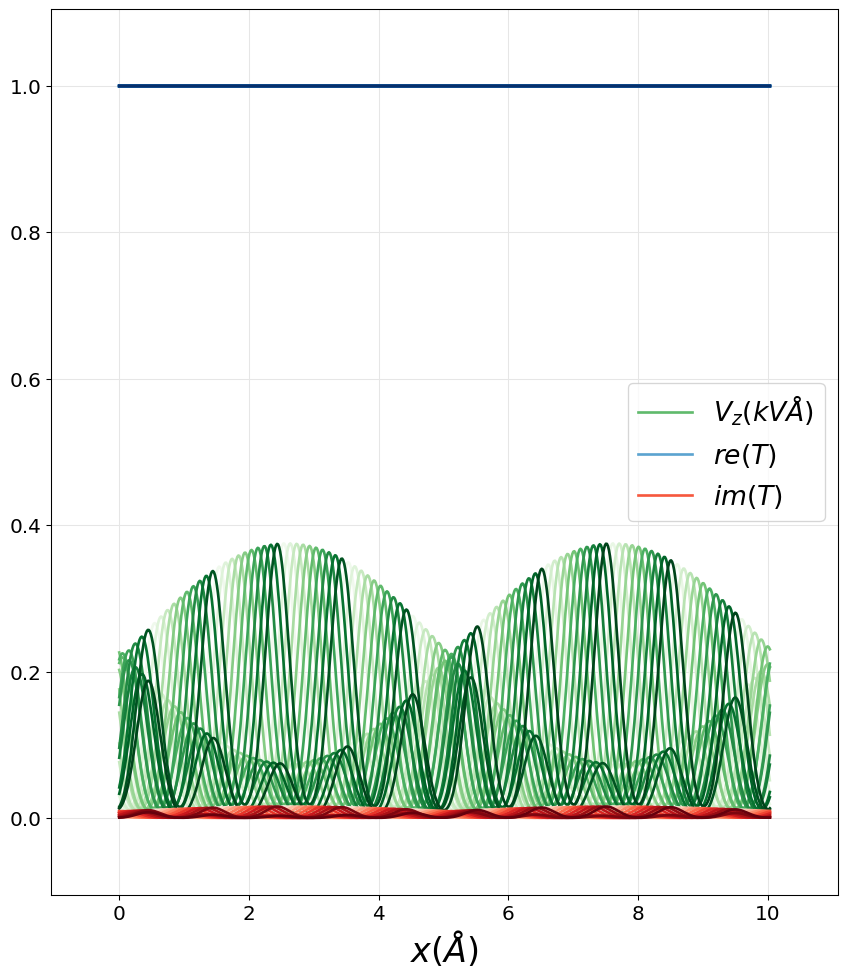

In [15]:
# ms0.Tz_show(Vopt='VT',lw=2)

In [ ]:
ms0.Xz_show(iZs=np.arange(0,1000,100),s_opt=True,lw=2,xylims=['x',0,1])

In [ ]:
# ms0.psi_xz[np.ix_(np.arange(100),np.arange(100))].shape
ms0.Xxz_show(iZs=np.arange(700),iXs=np.arange(10),s_opt=False,imOpt='c',axPos='V')#slice(1,ms0.z.size,10))

Below we plot the wave function in reciprocal space(1D diffraction pattern) at different thicknesses.As expected 2 extremely sharp peak concentrated with varying intensities.

In [ ]:
ms0.Qz_show(iZs=np.arange(0,750,105),opts='On',lw=2,xylims=[-3,3,-0.1,1])

We can also look at some selected beam as a function of sample thickness. Since the super cell is 10 times the lattice constant, the beam strongest beam index is found at index 10  which corresponds to miller index (1,0). It is clearly possible to measure the pendullosung thickness.

In [ ]:
ms0.Bz_show(np.arange(-3,3)*n,lw=2  ,name=path+'Iz.svg',opt=opt)

In [ ]:
ms0.dz
ms0.z[2]